https://data-dict.abcdstudy.org/?

In [1]:
import sys
print("Python version:", sys.version)

Python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]


In [4]:
import statsmodels
print("statsmodels version:", statsmodels.__version__)

statsmodels version: 0.12.2


In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered


In [2]:
import statsmodels.api as sm

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [60]:
import pandas as pd
import nilearn
import numpy as np
import glob 
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LogisticRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests


from pathlib import Path

from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import seaborn as sns

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.linear_model import LogisticRegression

%matplotlib inline


In [4]:
basepath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/'

In [13]:
df = pd.read_csv(os.path.join(basepath,'data','matched111724_centered_dum.csv'))  

In [14]:
# Get number of subjects
n = df.shape[0]
print(n)

3700


In [26]:
nonBrain = df[['demo_comb_income_v2','interview_age', 'bmi_perc',  'sex_M']]

In [27]:
nonBrain

,demo_comb_income_v2,interview_age,bmi_perc,sex_M
0,1.134865,2.208108,-0.074089,1
1,1.134865,-3.791892,-0.166220,0
2,-6.865135,2.208108,-0.117158,1
3,0.134865,-0.791892,0.181997,0
4,-3.865135,-0.791892,0.132754,0
...,...,...,...,...
3695,0.134865,6.208108,-0.089739,1
3696,1.134865,11.208108,-0.092898,0
3697,-0.865135,-4.791892,0.209150,0
3698,2.134865,12.208108,0.009343,1


In [28]:
ROIs = df.filter(like='rsfmri_', axis=1)

In [29]:
ROIs.shape

(3700, 416)

In [32]:
X = ROIs.join(nonBrain)

In [34]:
#3. Set sex to 0 for M and 1 for female  
X.replace({'sex': {'F': 1, 'M': 0}}, inplace=True)

In [35]:
X.shape

(3700, 420)

In [36]:
# Transpose the DataFrame to make columns become rows
X_T = X.T

duplicates = X_T.duplicated(keep='first')


In [37]:
# Identifying columns to drop (all duplicates except the first occurrence)
cols_to_drop = X_T[duplicates].index


In [38]:
# Drop the duplicate columns from the original DataFrame
X_cleaned = X.drop(cols_to_drop, axis=1)

print(X_cleaned)

      rsfmri_c_ngd_ad_ngd_ad  rsfmri_c_ngd_ad_ngd_cgc  rsfmri_c_ngd_ad_ngd_ca  \
0                   0.068443                -0.013937                0.043602   
1                   0.010384                 0.009812                0.017131   
2                  -0.021120                -0.001985                0.016845   
3                   0.039870                -0.018612               -0.093783   
4                   0.148359                -0.003445               -0.130025   
...                      ...                      ...                     ...   
3695                0.007844                -0.088140               -0.095973   
3696                0.128205                -0.015683               -0.118861   
3697                0.044244                 0.011726               -0.013017   
3698               -0.002446                 0.036297               -0.096342   
3699                0.041874                 0.008357               -0.036228   

      rsfmri_c_ngd_ad_ngd_d

In [ ]:
X.shape

In [ ]:
X_cleaned.shape

# Factor of interest
This is sometimes called the target. Right now I am using sex, but eventually we will change this to SSB group

In [43]:
# Convert 'high' to 1 and 'low' to 0
df['ssb_group'] = df['ssb_group'].map({'high': 1, 'low': 0})


In [44]:
y = df['ssb_group'] #target

In [45]:
y.value_counts()

1    1850
0    1850
Name: ssb_group, dtype: int64

# Train and test datasets
Get randomly generated train and test datasets
- Train 1 = train the model and feature elimination
- Train 2 = cross validate the model
- Test = test statistical differences

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, random_state=42)


In [47]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, random_state=42)
X_test.shape
y_test.value_counts()

0    481
1    444
Name: ssb_group, dtype: int64

In [48]:
anova_filter = SelectKBest(f_classif)
svm = SVC(kernel='linear')

anova_svm = Pipeline([
    ('anova', anova_filter),
    ('svc', svm)
])
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60],  # Trying different numbers of top features
    'svc__C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15],  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)
print(grid_search.best_params_)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('anova', SelectKBest()),
                                       ('svc', SVC(kernel='linear'))]),
             n_jobs=4,
             param_grid={'anova__k': [50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                                      60],
                         'svc__C': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11,
                                    0.12, 0.13, 0.14, 0.15]})

In [50]:
# Assuming anova_svm is your original pipeline
best_pipeline = Pipeline([
    ('anova', SelectKBest(f_classif)),  # You don't need to specify k here; it will be set by best_params_
    ('svc', SVC(kernel='linear'))      # No need to specify C here for the same reason
])

# Set the best parameters found for the entire pipeline
best_pipeline.set_params(**grid_search.best_params_)

# Now, retrain on the entire training set with the best parameters
best_pipeline.fit(X_train1, y_train1)

Pipeline(steps=[('anova', SelectKBest(k=50)),
                ('svc', SVC(C=0.05, kernel='linear'))])

In [51]:
# Predict on the test set
y_pred = best_pipeline.predict(X_train2)

# Evaluate the model
test_accuracy = accuracy_score(y_train2, y_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.7348703170028819


In [52]:
cm = confusion_matrix(y_train2, y_pred, normalize = 'true')
print(cm)

[[0.87215909 0.12784091]
 [0.40643275 0.59356725]]


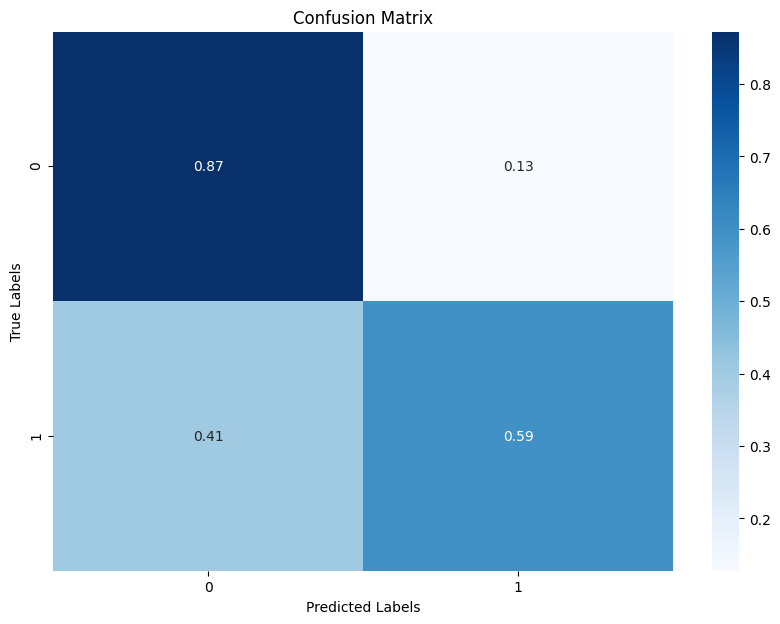

In [53]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True,  cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [54]:
# Access the best set of parameters found by GridSearchCV
best_parameters = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_parameters)

# Access the best estimator directly
best_model = grid_search.best_estimator_
print("Best model:", best_model)


Best parameters found by GridSearchCV: {'anova__k': 50, 'svc__C': 0.05}
Best model: Pipeline(steps=[('anova', SelectKBest(k=50)),
                ('svc', SVC(C=0.05, kernel='linear'))])


In [55]:
# Access the feature selection step ('anova' in your case)
feature_selection_step = best_model.named_steps['anova']


In [56]:
# Get the mask of selected features (boolean array)
selected_features_mask = feature_selection_step.get_support()



In [57]:
selected_features_mask.shape

(342,)

In [58]:
selected_columns = X_train.columns[selected_features_mask]


In [59]:
selected_columns

Index(['rsfmri_c_ngd_ad_ngd_cgc', 'rsfmri_c_ngd_ad_ngd_vs',
       'rsfmri_c_ngd_cgc_ngd_cgc', 'rsfmri_c_ngd_smh_ngd_smm',
       'rsfmri_c_ngd_sa_ngd_vta', 'rsfmri_cor_ngd_au_scs_aalh',
       'rsfmri_cor_ngd_au_scs_ptrh', 'rsfmri_cor_ngd_au_scs_vtdcrh',
       'rsfmri_cor_ngd_cerc_scs_cdelh', 'rsfmri_cor_ngd_cerc_scs_ptlh',
       'rsfmri_cor_ngd_cerc_scs_aglh', 'rsfmri_cor_ngd_cerc_scs_vtdclh',
       'rsfmri_cor_ngd_cerc_scs_hprh', 'rsfmri_cor_ngd_cerc_scs_agrh',
       'rsfmri_cor_ngd_cerc_scs_vtdcrh', 'rsfmri_cor_ngd_copa_scs_thplh',
       'rsfmri_cor_ngd_copa_scs_vtdclh', 'rsfmri_cor_ngd_copa_scs_crcxrh',
       'rsfmri_cor_ngd_copa_scs_plrh', 'rsfmri_cor_ngd_df_scs_ptlh',
       'rsfmri_cor_ngd_df_scs_pllh', 'rsfmri_cor_ngd_df_scs_aalh',
       'rsfmri_cor_ngd_none_scs_ptlh', 'rsfmri_cor_ngd_none_scs_thprh',
       'rsfmri_cor_ngd_none_scs_cderh', 'rsfmri_cor_ngd_rst_scs_bs',
       'rsfmri_cor_ngd_rst_scs_crcxrh', 'rsfmri_cor_ngd_rst_scs_thprh',
       'rsfmri_cor_ngd_rst_scs

# Regression

In [61]:
X_regression = X_test[selected_columns]

## Check high correlations between regions

In [62]:
correlation_matrix = X_regression.corr()


In [63]:
# Set the threshold for high correlation
threshold = 0.8

# Create a boolean mask for values above the threshold
high_corr_mask = np.abs(correlation_matrix) > threshold

# Mask the diagonal and lower triangle
mask_upper_triangle = np.triu(np.ones(high_corr_mask.shape), k=1).astype(np.bool)

# Combine masks
final_mask = high_corr_mask & mask_upper_triangle

/var/folders/02/zfp2v0gd46j44wl8qx8jxjtr0000gn/T/ipykernel_81482/3020619189.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_upper_triangle = np.triu(np.ones(high_corr_mask.shape), k=1).astype(np.bool)


In [64]:
# Apply mask to the correlation matrix
high_corr_pairs = correlation_matrix.where(final_mask)

# Stack the matrix and reset index to get pair-wise correlation in a readable format
stacked_corr_pairs = high_corr_pairs.stack().reset_index()
stacked_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

print(stacked_corr_pairs)

                        Feature 1                      Feature 2  Correlation
0      rsfmri_cor_ngd_au_scs_ptrh  rsfmri_cor_ngd_rst_scs_crcxrh     0.822824
1    rsfmri_cor_ngd_cerc_scs_aglh    rsfmri_cor_ngd_smh_scs_pllh     0.858514
2    rsfmri_cor_ngd_cerc_scs_hprh   rsfmri_cor_ngd_smh_scs_cderh     0.867641
3    rsfmri_cor_ngd_cerc_scs_agrh    rsfmri_cor_ngd_smh_scs_ptrh     0.831211
4  rsfmri_cor_ngd_cerc_scs_vtdcrh    rsfmri_cor_ngd_smh_scs_hprh     0.815776
5   rsfmri_cor_ngd_copa_scs_thplh    rsfmri_cor_ngd_smh_scs_aarh     0.877435
6  rsfmri_cor_ngd_copa_scs_vtdclh    rsfmri_cor_ngd_smm_scs_hplh     0.864477
7  rsfmri_cor_ngd_copa_scs_crcxrh    rsfmri_cor_ngd_smm_scs_aglh     0.805186


|ABCD|Human|
|---|----|
|rsfmri_cor_ngd_au_scs_ptrh|	Average correlation between auditory network and ASEG ROI right-putamen|
| rsfmri_cor_ngd_cerc_scs_aglh| Average correlation between cingulo-opercular network and ASEG ROI left-amygdala|
|rsfmri_cor_ngd_cerc_scs_hprh|cingulo-opercular network and ASEG ROI right-hippocampus	|
|rsfmri_cor_ngd_cerc_scs_vtdcrh| cingulo-opercular network and ASEG ROI right-ventraldc|
|rsfmri_cor_ngd_copa_scs_thplh|cingulo-parietal network and ASEG ROI left-thalamus-proper|
|rsfmri_cor_ngd_copa_scs_crcxrh |cingulo-parietal network and ASEG ROI right-cerebellum-cortex|
|sfmri_cor_ngd_rst_scs_crcxrh|retrosplenial temporal network and ASEG ROI right-cerebellum-cortex|
|rsfmri_cor_ngd_smh_scs_pllh|Average correlation between sensorimotor hand network and ASEG ROI left-pallidum|
|rsfmri_cor_ngd_smh_scs_cderh|Average correlation between sensorimotor hand network and ASEG ROI right-caudate|
|rsfmri_cor_ngd_smh_scs_hprh|sensorimotor hand network and ASEG ROI right-hippocampus|
|sfmri_cor_ngd_smh_scs_aarh	|sensorimotor hand network and ASEG ROI right-accumbens-area|
|rsfmri_cor_ngd_smm_scs_aglh|sensorimotor mouth network and ASEG ROI left-amygdala|

In [65]:
# Dropping cerebellar first
columns_to_drop_list = ['rsfmri_cor_ngd_rst_scs_crcxrh','rsfmri_cor_ngd_copa_scs_crcxrh']

X_regression_reduced = X_regression.drop(columns=columns_to_drop_list)



In [66]:
# Assuming X_scaled is your scaled feature matrix and it's a numpy array
#X_scaled_df = pd.DataFrame(X_scaled, columns=X_test_reg_sm.columns)  # Convert to DataFrame if necessary
#X_scaled_df_with_const = sm.add_constant(X_scaled_df)  # Add constant for VIF calculation

vifs = pd.Series([variance_inflation_factor(X_regression_reduced.values, i) 
                   for i in range(X_regression_reduced.shape[1])], 
                  index=X_regression_reduced.columns)

print(vifs) # looks OK, everything is under 10

rsfmri_c_ngd_ad_ngd_cgc           2.722862
rsfmri_c_ngd_ad_ngd_vs            1.592855
rsfmri_c_ngd_cgc_ngd_cgc          2.223601
rsfmri_c_ngd_smh_ngd_smm          1.946571
rsfmri_c_ngd_sa_ngd_vta           1.505130
rsfmri_cor_ngd_au_scs_aalh        2.456463
rsfmri_cor_ngd_au_scs_ptrh        4.515201
rsfmri_cor_ngd_au_scs_vtdcrh      2.087120
rsfmri_cor_ngd_cerc_scs_cdelh     3.946059
rsfmri_cor_ngd_cerc_scs_ptlh      3.709819
rsfmri_cor_ngd_cerc_scs_aglh      7.711133
rsfmri_cor_ngd_cerc_scs_vtdclh    1.210645
rsfmri_cor_ngd_cerc_scs_hprh      6.784987
rsfmri_cor_ngd_cerc_scs_agrh      5.261866
rsfmri_cor_ngd_cerc_scs_vtdcrh    4.022071
rsfmri_cor_ngd_copa_scs_thplh     6.482789
rsfmri_cor_ngd_copa_scs_vtdclh    5.591059
rsfmri_cor_ngd_copa_scs_plrh      2.830012
rsfmri_cor_ngd_df_scs_ptlh        2.306804
rsfmri_cor_ngd_df_scs_pllh        2.321724
rsfmri_cor_ngd_df_scs_aalh        1.463179
rsfmri_cor_ngd_none_scs_ptlh      3.790618
rsfmri_cor_ngd_none_scs_thprh     2.732196
rsfmri_cor_

In [67]:
result_sm = sm.add_constant(X_regression_reduced)

/Users/gracer/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


# Create train, test datasets for regression

In [68]:
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(result_sm, y_test, random_state=42)


In [69]:
X_testReg.shape

(232, 49)

In [70]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

In [71]:
# Fit the model on the training data
model.fit(X_trainReg, y_trainReg)

LogisticRegression(max_iter=1000)

In [72]:
# Predict on the test set
y_predReg = model.predict(X_testReg)

# Calculate the accuracy
accuracyReg = accuracy_score(y_testReg, y_predReg)
print(f"Accuracy: {accuracyReg}")


Accuracy: 0.6939655172413793


In [73]:
# Coefficients
coefficients = model.coef_
# Intercepts
intercepts = model.intercept_

In [76]:
selected_columns = X_trainReg.columns
coeff_df = pd.DataFrame(coefficients, columns=selected_columns)


In [77]:
coeff_df['Intercept'] = intercepts

In [80]:
class_names = ['low']  # Adjust as per your classes
coeff_df.index = class_names

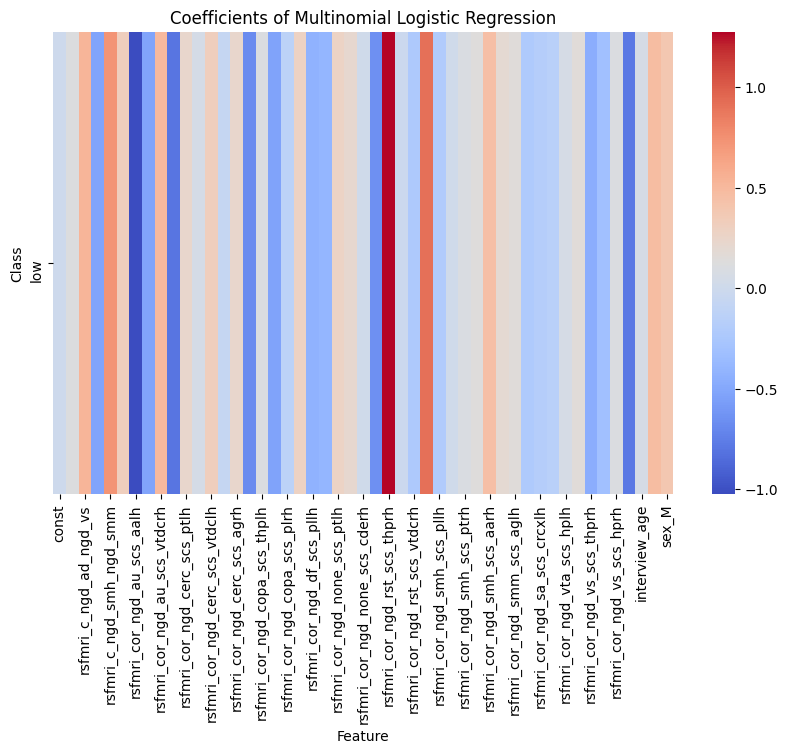

In [79]:
plt.figure(figsize=(10, 6))
sns.heatmap(coeff_df.iloc[:, :-1], annot=False, cmap='coolwarm')  # Exclude intercepts for visualization
plt.title('Coefficients of Multinomial Logistic Regression')
plt.ylabel('Class')
plt.xlabel('Feature')
plt.show()

In [81]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_testReg)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.428232
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              ssb_group   No. Observations:                  232
Model:                          Logit   Df Residuals:                      183
Method:                           MLE   Df Model:                           48
Date:                Sat, 23 Nov 2024   Pseudo R-squ.:                  0.3819
Time:                        07:23:11   Log-Likelihood:                -99.350
converged:                       True   LL-Null:                       -160.73
Covariance Type:            nonrobust   LLR p-value:                 1.787e-08
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -0.0603      0.311     -0.194     

In [82]:
# Making predictions
predictions = result.predict(X_testReg)

# Converting probabilities to class labels
class_predictions = np.where(predictions > 0.5, 1, 0)

In [83]:
array = y_testReg.to_numpy()

In [84]:
dfPrevReal = pd.DataFrame({'real': array, 'pred': class_predictions})

In [85]:
jaccard = jaccard_score(dfPrevReal['real'], dfPrevReal['pred'])
print("Jaccard Similarity Score:", jaccard)

Jaccard Similarity Score: 0.6212121212121212


In [86]:
# Extract p-values for all coefficients in the model
p_values = result.pvalues

In [87]:
result.pvalues

const                             8.459923e-01
rsfmri_c_ngd_ad_ngd_cgc           7.126159e-01
rsfmri_c_ngd_ad_ngd_vs            8.040992e-01
rsfmri_c_ngd_cgc_ngd_cgc          3.021206e-01
rsfmri_c_ngd_smh_ngd_smm          5.229689e-01
rsfmri_c_ngd_sa_ngd_vta           5.637830e-01
rsfmri_cor_ngd_au_scs_aalh        1.965349e-01
rsfmri_cor_ngd_au_scs_ptrh        6.259573e-01
rsfmri_cor_ngd_au_scs_vtdcrh      4.460617e-01
rsfmri_cor_ngd_cerc_scs_cdelh     3.132491e-01
rsfmri_cor_ngd_cerc_scs_ptlh      6.188473e-01
rsfmri_cor_ngd_cerc_scs_aglh      4.047473e-01
rsfmri_cor_ngd_cerc_scs_vtdclh    4.784918e-01
rsfmri_cor_ngd_cerc_scs_hprh      3.542967e-01
rsfmri_cor_ngd_cerc_scs_agrh      5.790313e-01
rsfmri_cor_ngd_cerc_scs_vtdcrh    1.903321e-01
rsfmri_cor_ngd_copa_scs_thplh     8.269350e-01
rsfmri_cor_ngd_copa_scs_vtdclh    3.542829e-02
rsfmri_cor_ngd_copa_scs_plrh      3.496048e-01
rsfmri_cor_ngd_df_scs_ptlh        6.032538e-01
rsfmri_cor_ngd_df_scs_pllh        7.283551e-01
rsfmri_cor_ng

In [88]:
# Apply Benjamini-Hochberg FDR correction
reject, pvals_corrected, _, _ = multipletests(p_values.values.flatten(), alpha=0.05, method='fdr_bh')

# Reshape the corrected p-values to match the original shape
pvals_corrected_reshaped = pvals_corrected.reshape(p_values.shape)

# Create a DataFrame of the corrected p-values for easier interpretation
# corrected_pvalues_df = pd.DataFrame(pvals_corrected_reshaped, index=p_values.index, columns=p_values.columns)

In [89]:
pvals_corrected_reshaped

array([9.56949135e-01, 9.15112762e-01, 9.56949135e-01, 8.76340208e-01,
       8.76340208e-01, 8.76340208e-01, 8.76340208e-01, 8.76340208e-01,
       8.76340208e-01, 8.76340208e-01, 8.76340208e-01, 8.76340208e-01,
       8.76340208e-01, 8.76340208e-01, 8.76340208e-01, 8.76340208e-01,
       9.56949135e-01, 5.78662006e-01, 8.76340208e-01, 8.76340208e-01,
       9.15112762e-01, 6.47617170e-01, 9.15112762e-01, 8.76340208e-01,
       8.76340208e-01, 5.78662006e-01, 8.76340208e-01, 9.80803463e-01,
       8.88689366e-01, 9.89202796e-01, 9.56949135e-01, 8.76340208e-01,
       8.76340208e-01, 8.76340208e-01, 8.76340208e-01, 6.47617170e-01,
       9.56949135e-01, 9.88433984e-01, 9.69070512e-01, 8.76340208e-01,
       8.76340208e-01, 6.47617170e-01, 8.76340208e-01, 8.76340208e-01,
       9.89202796e-01, 4.40817888e-05, 8.76340208e-01, 6.47617170e-01,
       8.76340208e-01])

In [97]:
saveDict = {'df': df, 'X': X, 'y': y, 'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test, 'best_pipeline':best_pipeline, 
            'X_reg':result_sm, 'X_trainReg':X_trainReg,'X_testReg':X_testReg, 'y_trainReg':y_trainReg, 'y_testReg':y_testReg,
            'logistic': result}

# Save results

In [99]:
import pickle
from datetime import datetime
from time import time


In [92]:
datefmt='%m-%d-%Y_%I-%M-%S'

In [93]:
def onetoughjar(path2dic):
    with open(path2dic, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

In [95]:
def adillyofapickle(basepath,dic, name):
    st = datetime.fromtimestamp(time()).strftime(datefmt)
    if os.path.exists(os.path.join(basepath,'tmp')):
        print('already have tmp')
    else:
        os.makedirs(os.path.join(basepath,'tmp'))
    pickle.dump(dic, open(os.path.join(basepath,'tmp','%s_%s'%(name,st)), 'wb'), protocol=4)

In [100]:
adillyofapickle(basepath,saveDict, 'SSBABCDanalysis')